<a href="https://colab.research.google.com/github/Mountagha/fromZeroToHero/blob/main/makemore_part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-04-28 02:26:25--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.009s  

2023-04-28 02:26:25 (23.2 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
words = open("names.txt", "r").read().splitlines()

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {c:i+1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3
def build_dataset(words):
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for c in w + '.':
      idx = stoi[c]
      X.append(context)
      Y.append(idx)
      # print(f"{''.join(itos[x] for x in context)} --> {c}")
      context = context[1:] + [idx]
    
  x = torch.tensor(X)
  y = torch.tensor(Y)
  print(x.shape, y.shape)
  return x, y

In [13]:
# training/validation/test
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


In [23]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vector
n_hidden = 200 # the number of the neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # For reproducibility
C = torch.randn((vocab_size, n_embd), generator=g, requires_grad=True)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g, requires_grad=True)
b1 = torch.randn(n_hidden, generator=g, requires_grad=True)
W2 = torch.randn((n_hidden, vocab_size), generator=g, requires_grad=True) * 0.01
b2 = torch.randn(vocab_size, generator=g, requires_grad=True) * 0
paramaters = [C, W1, b1, W2, b2]

In [24]:
print(sum(p.nelement() for p in paramaters)) # number of parameters in total

11897


In [25]:
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
  # minibatch construct
  idx = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[idx], Ytr[idx]

  # forward pass
  emb = C[Xb] # embed the charactesr into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  for p in paramaters:
    p.grad = None
  loss.backward()

  #update 
  # lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01 # learning rate decay
  for p in paramaters:
    p.data += -lr * p.grad
  
  # tracks stats
  if i % 10000 == 0: # print every once in a while
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())
  

<ipython-input-25-1f4303976c70>:27: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:486.)
  p.data += -lr * p.grad


TypeError: ignored

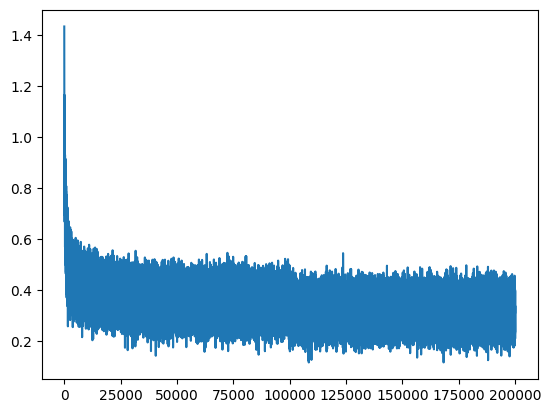

In [10]:
plt.plot(lossi)

In [16]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte)
  }[split]
  emb = C[x] # [N, block_size, n_embd]
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.12457013130188
val 2.122408866882324


In [ ]:
# text generation.
g = torch.Generator().manual_seed(32084209852)

context = [0] * block_size


torch.Size([1, 3, 10])

In [17]:
# sample from the model
g = torch.Generator().manual_seed(2147482647 + 10)
for _ in range(20):

  out = []
  context = [0] * block_size # initialize with all ....
  while True:
    # forward pass the neural network
    emb = C[torch.tensor([context])] # (1, block_size, n_embd)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    idx = torch.multinomial(probs, num_samples=1, generator=g).item()
    # Shift the context window and track the samples
    context = context[1:] + [idx]
    out.append(idx)
    if idx == 0:
      break
  print(''.join(itos[i] for i in out))

jae.
nar.
aayiah.
kolalas.
landa.
henson.
enro.
dhor.
yushamourgel.
shwette.
janniyannamari.
joem.
kiyah.
navia.
maristyn.
lian.
ema.
zucuan.
ashine.
nose.
